In [1]:
%matplotlib inline
# pandas for data manipulation
import pandas as pd
pd.options.mode.chained_assignment = None
# nltk for nlp
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
# list of stopwords like articles, preposition
stop = set(stopwords.words('english'))
from string import punctuation
from collections import Counter
import re
import numpy as np
from pandas import Series

In [2]:
#read the data from newspai.csv 
data = pd.read_csv('newsapi.csv')

In [3]:
data.shape

(2686, 9)

In [6]:
data.head(5)

,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date
0,http://www.abc.net.au/news/4172326,Court documents reveal a Queensland teenager's...,2017-09-11T14:47:37Z,abc-news-au,"Teen stabbed grandfather, applied bandaid, the...",http://www.abc.net.au/news/2017-09-11/robert-w...,http://www.abc.net.au/news/image/8760378-1x1-7...,general,2017-09-11 10:55:03.043011
1,http://www.abc.net.au/news/jonathan-hepburn/71...,With same-sex marriage about to be put to a po...,2017-09-11T14:30:37Z,abc-news-au,Same-sex marriage? Q&A asks whether we should ...,http://www.abc.net.au/news/2017-09-12/q-and-a-...,http://www.abc.net.au/news/image/8894140-1x1-7...,general,2017-09-11 10:55:03.043011
2,http://www.abc.net.au/news/louise--yaxley/5553...,Energy provider AGL appears to be committed to...,2017-09-11T14:05:33Z,abc-news-au,AGL appears committed to closing Liddell plant...,http://www.abc.net.au/news/2017-09-11/agl-appe...,http://www.abc.net.au/news/image/8877002-1x1-7...,general,2017-09-11 10:55:03.043011
3,http://www.abc.net.au/news/linton-besser/7278682,The Government has released a wide-ranging rep...,2017-09-11T14:06:43Z,abc-news-au,Many tipped the report on alleged water corrup...,http://www.abc.net.au/news/2017-09-11/murray-d...,http://www.abc.net.au/news/image/7219978-1x1-7...,general,2017-09-11 10:55:03.043011
4,http://www.abc.net.au/news/ruby-jones/5939968,The trend of Australian high school students g...,2017-09-11T14:03:43Z,abc-news-au,'It's not good for the kids': Push to end orph...,http://www.abc.net.au/news/2017-09-12/world-ch...,http://www.abc.net.au/news/image/8892626-1x1-7...,general,2017-09-11 10:55:03.043011


### distribution of the different categories across the dataset.

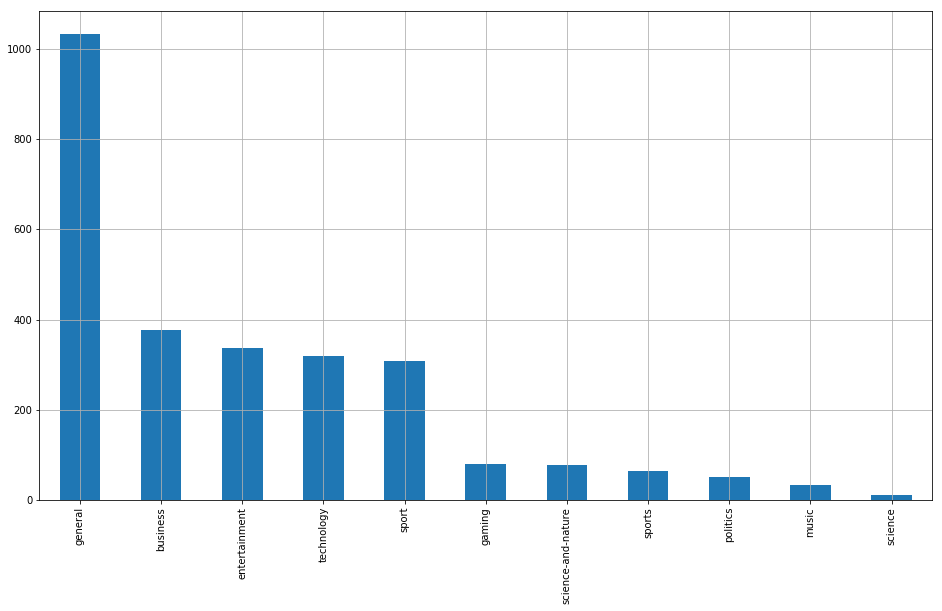

In [7]:
#Check the distribution of the different categories across the dataset.
data.category.value_counts().plot(kind='bar', grid=True, figsize=(16, 9))

### distribution of the different sources across the dataset.

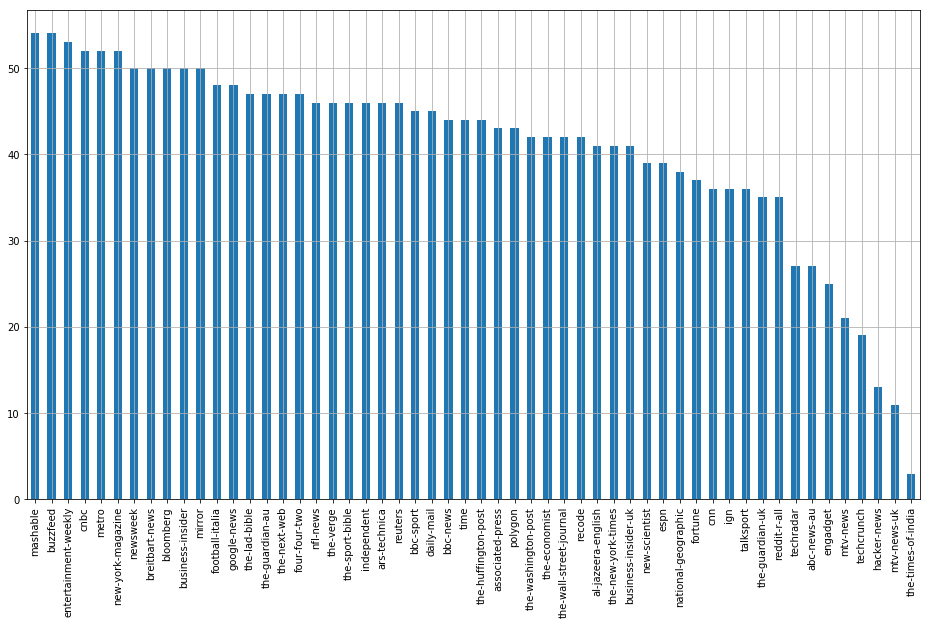

In [6]:
data.source.value_counts().plot(kind='bar', grid=True, figsize=(16, 9))

In [8]:
# remove duplicate description columns
data = data.drop_duplicates('description')

In [9]:
# remove rows with empty descriptions
data = data[~data['description'].isnull()]

In [10]:
data.shape

(2611, 9)

In [11]:
data['len'] = data['description'].map(len)

In [12]:
data = data[data.len > 140]
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

In [13]:
data.shape

(900, 10)

###  Text processing : tokenization
#### Now we start by building a tokenizer. This will, for every description:
#### break the descriptions into sentences and then break the sentences into tokens
#### remove punctuation and stop words
##### lowercase the tokens

In [14]:
#break the descriptions into sentences and then break the sentences into tokens
#remove punctuation and stop words
#lowercase the tokens

def tokenizer(text):
    try:
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
        
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent

        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', 
                                            u'\u2014', u'\u2026', u'\u2013'], tokens))
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)

        filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

        return filtered_tokens
    except Error as e:
        print(e)

### New column 'tokens' can be easily created using the map method applied to the 'description' column.
#### The tokenizer has been applied to each description through all rows. Each resulting value is then put into the 'tokens' column that is created after the assignment. Tokenization for the first 5 descriptions:

In [15]:
#A new column 'tokens' can be easily created using the map method applied to the 'description' column.
data['tokens'] = data['description'].map(tokenizer)

In [16]:
for descripition, tokens in zip(data['description'].head(5), data['tokens'].head(5)):
    print('description:', descripition)
    print('tokens:', tokens)
    print() 

description: With same-sex marriage about to be put to a postal survey of the electorate, Q&A raised the much more basic question of whether marriage has any place in society at all, or is a sexist, dangerous institution we should get rid of.
tokens: ['same-sex', 'marriage', 'put', 'postal', 'survey', 'electorate', 'q', 'raised', 'much', 'basic', 'question', 'whether', 'marriage', 'place', 'society', 'sexist', 'dangerous', 'institution', 'get', 'rid']

description: Up to a third of Australian mortgages could be liar loans based on inaccurate information, warns investment bank UBS, raising the risk of widespread home loan defaults.
tokens: ['third', 'australian', 'mortgages', 'could', 'liar', 'loans', 'based', 'inaccurate', 'information', 'warns', 'investment', 'bank', 'ubs', 'raising', 'risk', 'widespread', 'home', 'loan', 'defaults']

description: TAMPA, Fla. (AP) — Hurricane Irma weakened into a still-dangerous tropical storm Monday as it pushed inland, triggering record flooding in 

### group the tokens by category, apply a word count and display the top 10 most frequent tokens

In [17]:
#group the tokens by category, apply a word count and display the top 10 most frequent tokens

def keywords(category):
    tokens = data[data['category'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

In [56]:
for category in set(data['category']):
    print('category :', category)
    print('top 10 keywords:', keywords(category))
    print('---')

category : technology
top 10 keywords: [('iphone', 12), ('apple', 10), ('new', 9), ('google', 6), ('work', 6), ('company', 6), ('today', 5), ('transport', 5), ('like', 5), ('mi', 5)]
---
category : sport
top 10 keywords: [('league', 16), ('season', 11), ('premier', 11), ('win', 10), ('ldquo', 9), ('rdquo', 9), ('week', 9), ('nfl', 9), ('sunday', 7), ('could', 7)]
---
category : general
top 10 keywords: [('trump', 41), ('said', 34), ('u.s.', 25), ('president', 23), ('donald', 22), ('friday', 21), ('new', 21), ('ap', 20), ('monday', 17), ('hurricane', 17)]
---
category : science-and-nature
top 10 keywords: [('system', 4), ('far', 3), ('physical', 2), ('unknown', 2), ('per', 2), ('cent', 2), ('close', 2), ('systems', 2), ('help', 2), ('new', 2)]
---
category : gaming
top 10 keywords: [('revival', 1), ('filled', 1), ('problems', 1), ('years', 1), ('beauty', 1), ('fils-aime', 1), ('company', 1), ('peaks', 1), ('classic', 1), ('outside', 1)]
---
category : music
top 10 keywords: [('keraun', 

### Text processing : tf-idf
#### tf-idf stands for term frequencey-inverse document frequency. It's a numerical statistic intended to reflect how important a word is to a document or a corpus (i.e a collection of documents). Computing the tfidf matrix is done using the TfidfVectorizer method from scikit-learn.

In [18]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

vectorizer = TfidfVectorizer(min_df=10, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = vectorizer.fit_transform(list(data['description']))

In [19]:
vz.shape

(900, 389)

### vz is a tfidf matrix.
#### its number of rows is the total number of documents (descriptions)
#### its number of columns is the total number of unique terms (tokens) across the documents (descriptions)
### x_dt = tfidf(t,d) where x_dt is the element at the index (d,t) in the matrix.
#### Let's create a dictionary mapping the tokens to their tfidf values

In [20]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

### visualize the distribution of the tfidf scores through an histogram

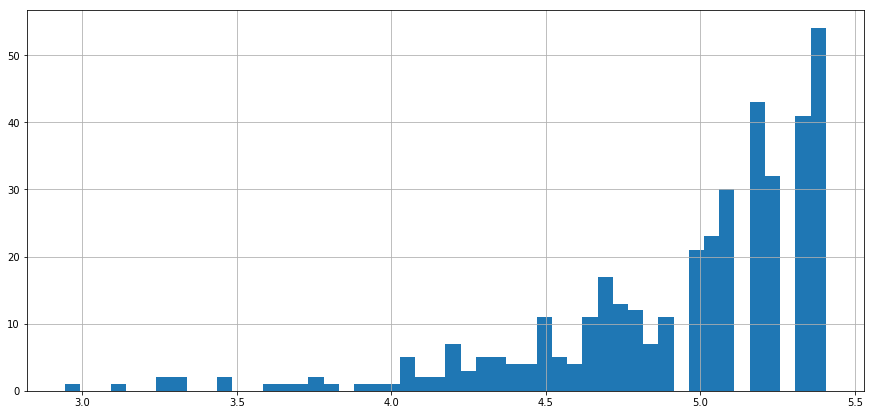

In [21]:
tfidf.tfidf.hist(bins=50, figsize=(15,7))

### display the 30 tokens that have the lowest tfidf score
### a list of very generic words. These are very common across many descriptions. tfidf attributes a low score to them as a penalty for not being relevant. Words likes may, one, new, back, etc.

In [22]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(30)

,tfidf
said,2.943693
trump,3.093975
new,3.239157
monday,3.249628
u.s.,3.292646
president,3.314869
donald,3.459700
donald trump,3.472772
one,3.598813
sunday,3.644622


### 30 words with the highest tfidf scores.

In [23]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(30)

,tfidf
claims,5.40561
soon,5.40561
health,5.40561
jong un,5.40561
rights,5.40561
department,5.40561
jong,5.40561
nations,5.40561
seen,5.40561
known,5.40561


In [24]:
vz.shape

(900, 389)

### the documents have more than features (see the vz shape). put differently, each document has more than  dimensions.
### If we want to plot them like we usually do with geometric objects, we need to reduce their dimension to 2 or 3 depending on whether we want to display on a 2D plane or on a 3D space. This is what we call dimensionality reduction.
### To perform this task, we'll be using a combination of two popular techniques: Singular Value Decomposition (SVD) to reduce the dimension to 50 and then t-SNE to reduce the dimension from 50 to 2. t-SNE is more suitable for dimensionality reduction to 2 or 3.
### Let's start reducing the dimension of each vector to 50 by SVD.

In [25]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(vz)

In [26]:
svd_tfidf.shape

(900, 50)

In [27]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 900 / 900
[t-SNE] Mean sigma: 0.229392
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.932959
[t-SNE] Error after 175 iterations: 0.932959


In [28]:
tsne_tfidf.shape

(900, 2)

In [29]:
tsne_tfidf

array([[ -3.47253894,   1.90938491],
       [-15.64957301,   5.14510194],
       [  6.99987013,  12.7477731 ],
       ..., 
       [ -1.14703139, -10.6524898 ],
       [ -4.60759892,  -2.00152664],
       [  9.65544783,  -0.4682482 ]])

In [30]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

In [31]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

Loading BokehJS ...

In [32]:
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['description'] = data['description']
tfidf_df['category'] = data['category']

In [33]:
plot_tfidf.scatter(x='x', y='y', source=tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category":"@category"}
show(plot_tfidf)

### Clustering:  KMeans
### Our starting point is the tf-idf matrix vz. 
### One thing to know about Kmeans is that it needs the number of clusters up front. This number is usually found by trying different values until the result looks satisfactory.
### I found that 20 was a good number that separates the dataset nicely.

In [34]:
vz.shape

(900, 389)

In [35]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.cluster import MiniBatchKMeans

num_clusters = 30
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

### Let's see the five first description and the associated cluster

In [36]:
for (i, desc),category in zip(enumerate(data.description),data['category']):
    if(i < 5):
        print("Cluster " + str(kmeans_clusters[i]) + ": " + desc + 
              "(distance: " + str(kmeans_distances[i][kmeans_clusters[i]]) + ")")
        print('category: ',category)
        print('---')

Cluster 14: With same-sex marriage about to be put to a postal survey of the electorate, Q&A raised the much more basic question of whether marriage has any place in society at all, or is a sexist, dangerous institution we should get rid of.(distance: 0.994235814811)
category:  general
---
Cluster 14: Up to a third of Australian mortgages could be liar loans based on inaccurate information, warns investment bank UBS, raising the risk of widespread home loan defaults.(distance: 0.988865143326)
category:  general
---
Cluster 14: TAMPA, Fla. (AP) — Hurricane Irma weakened into a still-dangerous tropical storm Monday as it pushed inland, triggering record flooding in Florida's northeastern corner, while rescuers in its soggy, wind-battered wake mobilized to reach victims and learn the full extent of the damage. The storm engulfed nearly the entire Florida peninsula, wreaking havoc from the state's southernmost point up to the Georgia line, from the Atlantic coast to the Gulf side. It swamp

### This doesn't tell us much. What we need to look up are the "hot" keywords that describe each clusters.

In [37]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    aux = ''
    for j in sorted_centroids[i, :10]:
        aux += terms[j] + ' | '
    print(aux)
    print() 

Cluster 0:
senate | republicans | latest | would | chairman | million | support | gop | least | nearly | 

Cluster 1:
last year | year | last | may | lost | largest | government | world | state | young | 

Cluster 2:
reports | expected | ahead | data | three | least | facebook | year | tuesday | first | 

Cluster 3:
north | north korea | korea | minister | foreign minister | foreign | war | u.s. | pyongyang | country | 

Cluster 4:
anthem | national | national anthem | nfl | players | league | president | donald trump | donald | trump | 

Cluster 5:
one | young | made | make | right | also | hurricane irma | help | got | government | 

Cluster 6:
travel | ban | countries | trump | administration | donald trump | donald | president | court | trump administration | 

Cluster 7:
eu | theresa | theresa may | brexit | may | britain | uk | prime minister | prime | minister | 

Cluster 8:
trump | president | donald trump | donald | president donald | alabama | strange | luther | luther strang

### Let's plot these clusters. To do this we need to reduce the dimensionality of kmeans_distances to 2.

In [42]:
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 591 / 591
[t-SNE] Mean sigma: 0.090966
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.544106
[t-SNE] Error after 175 iterations: 0.544106


### Let's use a color palette to assign different colors to each cluster

In [43]:
import numpy as np

colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#7d6d33", "#d27c88", "#36422b", "#b68f79"])

plot_kmeans = bp.figure(plot_width=700, plot_height=600, title="KMeans clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [44]:
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['description'] = data['description']
kmeans_df['category'] = data['category']

In [45]:
plot_kmeans.scatter(x='x', y='y', 
                    color=colormap[kmeans_clusters], 
                    source=kmeans_df)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category": "@category", "cluster":"@cluster"}
show(plot_kmeans)

### It looks like clusters are separated nicely. By hovering on each one of them you can see the corresponding descriptions. At first sight you could notice that they deal approximately with the same topic. This is coherent since we build our clusters using similarities between relevant keywords.
### We can also notice that within the same cluster, many subclusters are isolated from one another. This gives an idea about the global topic as well as the
### Kmeans separates the documents into disjoint clusters. the assumption is that each cluster is attributed a single topic.
### However, descriptions may in reality be characterized by a "mixture" of topics. We'll cover how to deal with this problem with the LDA algorithm.

In [46]:
#LDA on the data set. We'll set the number of topics to 20.
import lda
from sklearn.feature_extraction.text import CountVectorizer

In [47]:
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

In [48]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
cvectorizer = CountVectorizer(min_df=4, max_features=10000, tokenizer=tokenizer, ngram_range=(1,2))
cvz = cvectorizer.fit_transform(data['description'])

n_topics = 20
n_iter = 2000
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)

In [60]:
n_top_words = 8
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: home police first night time man woman five
Topic 1: league premier premier league manchester games team top england
Topic 2: could according past next companies new systems system
Topic 3: said may minister uk eu brexit prime prime minister
Topic 4: week one could say much going get time
Topic 5: trump president donald donald trump president donald political us america
Topic 6: would says bill latest care republicans health repeal
Topic 7: hurricane irma florida storm hurricane irma maria power hit
Topic 8: go london uber company transport saturday ldquo rdquo
Topic 9: new said york new york friday federal attacks sexual
Topic 10: house white news former white house bannon breitbart steve
Topic 11: told man hours church right adding university money
Topic 12: nfl sunday players football national anthem game league
Topic 13: moore alabama judge former senate tuesday roy u.s.
Topic 14: years one like monday far year ago know
Topic 15: alabama party strange race luther senator l

In [61]:
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 591 / 591
[t-SNE] Mean sigma: 0.210172
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.738389
[t-SNE] Error after 175 iterations: 0.738389


In [62]:
doc_topic = lda_model.doc_topic_
lda_keys = []
for i, tweet in enumerate(data['description']):
    lda_keys += [doc_topic[i].argmax()]

In [63]:
plot_lda = bp.figure(plot_width=700, plot_height=600, title="LDA topic visualization",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [64]:
lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['description'] = data['description']
lda_df['category'] = data['category']

In [65]:
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

In [66]:
plot_lda.scatter(source=lda_df, x='x', y='y', color=colormap[lda_keys])

hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"description":"@description", "topic":"@topic", "category":"@category"}
show(plot_lda)

In [67]:
lda_df['len_docs'] = data['tokens'].map(len)

In [68]:
def prepareLDAData():
    data = {
        'vocab': vocab,
        'doc_topic_dists': lda_model.doc_topic_,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency':cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

In [69]:
ldadata = prepareLDAData()


In [72]:
import pyLDAvis


### Visualization of the topics using pyLDAvis

In [73]:
pyLDAvis.enable_notebook()

In [74]:
prepared_data = pyLDAvis.prepare(**ldadata)

/Users/sanjay/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [75]:
prepared_data


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
1      6.642088        1       1  0.146723  0.024647
16     6.338942        1       2 -0.187413  0.073767
0      6.310131        1       3  0.141630 -0.049022
5      5.879658        1       4 -0.004681  0.092549
4      5.709821        1       5  0.182229  0.059145
18     5.614330        1       6  0.091584  0.123889
12     5.340495        1       7  0.210766 -0.012817
2      5.191711        1       8  0.041012  0.098896
7      5.135568        1       9  0.015897 -0.150954
17     4.940797        1      10 -0.215359  0.034479
9      4.805507        1      11 -0.143566  0.209123
14     4.726508        1      12  0.058266  0.065257
19     4.600258        1      13 -0.148639  0.092294
3      4.426888        1      14 -0.118336  0.048313
6      4.239793        1      15 -0.018707 -0.201924
13     4.206938        1      16 -0.144022 -0.228082
11     4.159701        1      17  0.080291 -0.004085
10     4.090241        1      18 -0.010453 -0.092720
8      3.888204        1      19  0.069223  0.033133
15     3.752421        1      20 -0.046443 -0.215889, topic_info=     Category        Freq              Term       Total  loglift  logprob
term                                                                     
813   Default  155.000000             trump  155.000000  30.0000  30.0000
590   Default  110.000000         president  110.000000  29.0000  29.0000
219   Default   94.000000            donald   94.000000  28.0000  28.0000
220   Default   92.000000      donald trump   92.000000  27.0000  27.0000
664   Default  147.000000              said  147.000000  26.0000  26.0000
520   Default  142.000000               new  142.000000  25.0000  25.0000
591   Default   72.000000  president donald   72.000000  24.0000  24.0000
351   Default   59.000000         hurricane   59.000000  23.0000  23.0000
868   Default   60.000000              week   60.000000  22.0000  22.0000
546   Default   89.000000               one   89.000000  21.0000  21.0000
529   Default   62.000000             north   62.000000  20.0000  20.0000
825   Default  107.000000              u.s.  107.000000  19.0000  19.0000
525   Default   52.000000               nfl   52.000000  18.0000  18.0000
402   Default   52.000000             korea   52.000000  17.0000  17.0000
491   Default  111.000000            monday  111.000000  16.0000  16.0000
170   Default   72.000000             could   72.000000  15.0000  15.0000
891   Default   53.000000             would   53.000000  14.0000  14.0000
530   Default   50.000000       north korea   50.000000  13.0000  13.0000
751   Default   77.000000            sunday   77.000000  12.0000  12.0000
286   Default   56.000000            former   56.000000  11.0000  11.0000
348   Default   39.000000             house   39.000000  10.0000  10.0000
23    Default   50.000000           alabama   50.000000   9.0000   9.0000
442   Default   48.000000            london   48.000000   8.0000   8.0000
895   Default   46.000000             years   46.000000   7.0000   7.0000
799   Default   45.000000              told   45.000000   6.0000   6.0000
822   Default   50.000000               two   50.000000   5.0000   5.0000
522   Default   33.000000              news   33.000000   4.0000   4.0000
875   Default   33.000000             white   33.000000   3.0000   3.0000
419   Default   51.000000            league   51.000000   2.0000   2.0000
309   Default   32.000000                go   32.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
754   Topic20    9.981373        supporters   10.303639   3.2510  -3.9400
418   Topic20    9.981373           leaders   10.303639   3.2510  -3.9400
690   Topic20    8.320579    senator luther    8.642845   3.2448  -4.1220
715   Topic20    8.320579      social media    8.642845   3.2448  -4.1220
584   Topic20    6.659785              poll    6.9820